# Preparation of Dataset for solubility prediction

## Datasets

1. [ESOL: Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x)
2. [AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds](https://www.nature.com/articles/s41597-019-0151-1)
3. [Is Experimental Data Quality the Limiting Factor in Predicting the Aqueous Solubility of Driglike Molecules](https://pubs.acs.org/doi/full/10.1021/mp500103r)

## Backgroud:

Aqueous solubility is a key factor in drug discovery, since if a molecule is not soluble. it will typically be poorly bioavailable, making it difficult to perform <i>in-vivo</i> studies with it, and hence deliver to patients.

In [301]:
! pip install rdkit pandas numpy

In [302]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

In [303]:
def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [304]:
esol = load_csv(path="data/esol.csv")
aqsol = load_csv(path="data/solubility-dataset-train.csv")
dsl = load_csv(path="data/dsl-100-unique.csv")

In [305]:
print(esol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

In [306]:
print(aqsol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

In [307]:
print(dsl.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     56 non-null     int64  
 1   Chemical name                  56 non-null     object 
 2   Crystal structure CSD refcode  56 non-null     object 
 3   LogS exp (mol/L)               56 non-null     float64
 4   Reference                      56 non-null     int64  
 5   Test                           56 non-null     bool   
 6   SMILES                         56 non-null     object 
 7   Smiles Source                  56 non-null     object 
 8   Chemspider reference number    56 non-null     int64  
 9   InChl                          56 non-null     object 
 10  cansmi                         56 non-null     object 
 11  is_unique                      56 non-null     bool   
dtypes: bool(2), float64(1), int64(3), object(6)
memory u

## Calculating Molecular Descriptors

To predict log(S), the study of Delaney used four molecular descriptors:
- cLogP (Octanol-Water partition coefficient)
- MW (Molecular Weight)
- RB (Number of rotatable bonds)
- AP (Aromatic proportion = Number of aromatic atoms / total number of heavy atoms)

In [308]:
def get_number_aromatic_atoms(molecule) -> int:
    
    aromatic_atoms = [molecule.GetAtomWithIdx(idx).GetIsAromatic() for idx in range(molecule.GetNumAtoms())]
    count = []
    for _, value in enumerate(aromatic_atoms):
        if value == True:
            count.append(value)
    sum_count = sum(count)
    
    return sum_count

In [309]:
def calc_aromatic_descriptors(molecule) -> float:
    aromatic_atoms: int = get_number_aromatic_atoms(molecule)
    num_heavy_atoms: int = Descriptors.HeavyAtomCount(molecule)
    
    aromatic_proportion: float = aromatic_atoms / num_heavy_atoms
    return aromatic_proportion

In [310]:
def generate_dataset(molecules) -> pd.DataFrame:
    smiles = []
    rows = []

    for molecule in molecules:
        descriptor = Chem.MolFromSmiles(molecule)
        smiles.append(descriptor)
    
    for smile in smiles:
        mol_log_p: float = Descriptors.MolLogP(smile)
        mol_weight: float = Descriptors.MolWt(smile)
        num_rot_bonds: int = Descriptors.NumRotatableBonds(smile)
        aromatic_proportion: float = calc_aromatic_descriptors(smile)
        
        row = [smile, mol_log_p, mol_weight, num_rot_bonds, aromatic_proportion]
        rows.append(row)
    
    df = pd.DataFrame(data=rows, columns=["SMILES", "MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"])
    return df

In [311]:
esol_parsed = generate_dataset(molecules=esol["smiles"])
aqsol_parsed = generate_dataset(molecules=aqsol["SMILES"])
dsl_parsed = generate_dataset(molecules=dsl["SMILES"])

[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:56] WARNING: not removing hydrogen atom without neighbors
[02:22:57] WARNING: not removing hydrogen atom without neighbors
[02:22:57] WARNING: not removing hydrogen atom without neighbors
[02:22:57] WARNING: not removing hydrogen atom without neighbors
[02:22:57] WARNING: not r

In [312]:
esol.columns.values # y = measured log solubility in mols / L

array(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds',
       'Polar Surface Area', 'measured log solubility in mols per litre',
       'smiles'], dtype=object)

In [313]:
aqsol.columns.values # y = Solubility (reported as LogS (mol/L))

array(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR',
       'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
       'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings',
       'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA',
       'LabuteASA', 'BalabanJ', 'BertzCT'], dtype=object)

In [314]:
dsl.columns.values # y = LogS exp (mol/L)

array(['Unnamed: 0', 'Chemical name', 'Crystal structure CSD refcode',
       'LogS exp (mol/L)', 'Reference', 'Test', 'SMILES', 'Smiles Source',
       'Chemspider reference number', 'InChl', 'cansmi', 'is_unique'],
      dtype=object)

In [315]:
from sklearn.preprocessing import StandardScaler

tmp_train = pd.concat([esol_parsed, aqsol_parsed], axis=0)
X_train = tmp_train[["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"]]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
train_dataset = pd.DataFrame(columns=["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"], data=X_train)

y, y_aqsol = list(esol["measured log solubility in mols per litre"]), list(aqsol["Solubility"])
y.extend(y_aqsol)

train_dataset["y"] = y

train_dataset.head()


,MolLogP,MolWeight,NumRotatableBonds,AromaticProportion,y
0,-1.514901,1.103667,0.572566,-0.435543,-0.77
1,0.239799,-0.330717,-0.345172,1.368067,-3.30
2,0.250914,-0.604978,0.021923,-1.055104,-2.06
3,1.260193,0.101092,-0.712267,2.249220,-7.87
4,-0.082395,-0.986205,-0.712267,2.249220,-1.33


array([[<AxesSubplot: title={'center': 'MolLogP'}>,
        <AxesSubplot: title={'center': 'MolWeight'}>],
       [<AxesSubplot: title={'center': 'NumRotatableBonds'}>,
        <AxesSubplot: title={'center': 'AromaticProportion'}>]],
      dtype=object)

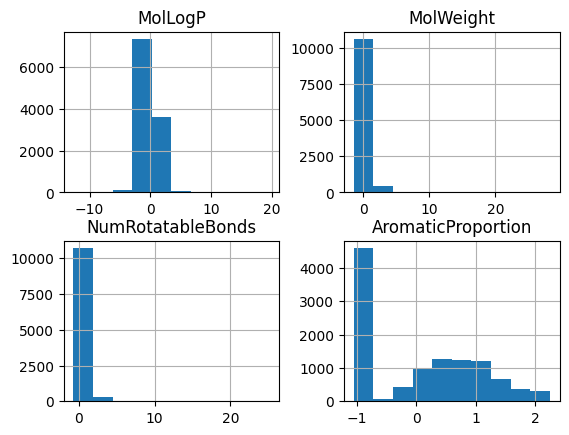

In [316]:
pd.DataFrame(columns=["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"], data=X_train).hist()

In [317]:
X_test = dsl_parsed[["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"]]
X_test = scaler.transform(X_test)
test_dataset = pd.DataFrame(columns=["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"], data=X_test)
test_dataset["y"] = dsl["LogS exp (mol/L)"]

test_dataset.head()

,MolLogP,MolWeight,NumRotatableBonds,AromaticProportion,y
0,-1.182146,0.038898,-0.345172,0.510102,-1.73
1,-0.580809,-0.695244,-0.712267,1.918788,-2.26
2,-0.227087,0.168101,0.205471,0.833081,-2.95
3,-0.189564,-0.773573,-0.528719,1.147779,-1.58
4,-0.212810,-0.117469,0.021923,0.111128,-1.22


In [318]:
print("Training dataset: ", train_dataset.shape)
print("Testing dataset: ", test_dataset.shape)

Training dataset:  (11110, 5)
Testing dataset:  (56, 5)


array([[<AxesSubplot: title={'center': 'MolLogP'}>,
        <AxesSubplot: title={'center': 'MolWeight'}>],
       [<AxesSubplot: title={'center': 'NumRotatableBonds'}>,
        <AxesSubplot: title={'center': 'AromaticProportion'}>]],
      dtype=object)

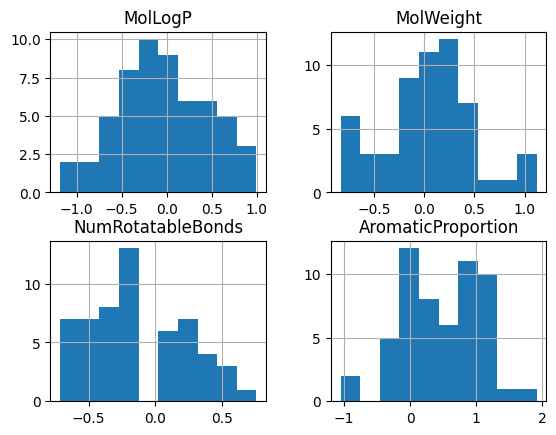

In [319]:
pd.DataFrame(columns=["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"], data=X_test).hist()

In [320]:
train_dataset[train_dataset.duplicated()]

,MolLogP,MolWeight,NumRotatableBonds,AromaticProportion,y
365,-0.457474,-1.008896,-0.712267,2.249220,1.100
465,-0.391455,-0.157084,-0.345172,0.111128,-2.322
500,0.545963,0.747723,0.756113,-0.193106,-6.340
612,-0.097044,-0.857366,-0.712267,1.423139,0.380
886,0.005365,-0.737546,-0.712267,1.423139,-0.700
...,...,...,...,...,...
11012,1.547690,0.563128,-0.528719,1.147779,-8.560
11073,-0.423344,0.762235,0.389018,-0.419657,-2.940
11079,0.011501,0.543550,-0.161624,0.215790,-2.900
11098,0.337995,0.359017,0.021923,0.321698,-2.790


In [321]:
! pip install scikit-learn lightgbm xgboost

In [322]:
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

X_dataset, y = train_dataset[["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"]], train_dataset["y"]


models = {
    "linear-regression": LinearRegression().fit(X_dataset, y),
    "random-forest": RandomForestRegressor().fit(X_dataset, y),
    "lightgbm-regressor": LGBMRegressor().fit(X_dataset, y),
    "xgboost-regressor": XGBRegressor().fit(X_dataset, y)
}

for key, model in models.items():
    print(f"Training dataset statistics: {key} \n")
    
    pred_train = model.predict(X_dataset)
    
    if key == "linear-regression":
        print("Coefficients: ", model.coef_)
        print("Intercept: ", model.intercept_)
        
    print(f"RMSE: {math.sqrt(mean_squared_error(y, pred_train)):.3f}")
    print(f"MAE: {mean_absolute_error(y, pred_train):.3f}")
    print(f"Coefficient of Correlation: {r2_score(y, pred_train):.3f}")
    
    print("===============================================\n")



Training dataset statistics: linear-regression 

Coefficients:  [-1.35620427 -0.73790469  0.41853347 -0.22668507]
Intercept:  -2.90617323936847
RMSE: 1.716
MAE: 1.254
Coefficient of Correlation: 0.464

Training dataset statistics: random-forest 

RMSE: 0.479
MAE: 0.318
Coefficient of Correlation: 0.958

Training dataset statistics: lightgbm-regressor 

RMSE: 1.101
MAE: 0.782
Coefficient of Correlation: 0.779

Training dataset statistics: xgboost-regressor 

RMSE: 0.877
MAE: 0.627
Coefficient of Correlation: 0.860



In [323]:
X_test, y_test = test_dataset[["MolLogP", "MolWeight", "NumRotatableBonds", "AromaticProportion"]], test_dataset["y"]

for key, model in models.items():
    print(f"Training dataset statistics: {key} \n")
    
    pred_train = model.predict(X_test)
        
    print(f"RMSE: {math.sqrt(mean_squared_error(y_test, pred_train)):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, pred_train):.3f}")
    print(f"Coefficient of Correlation: {r2_score(y_test, pred_train):.3f}")
    
    print("===============================================\n")

Training dataset statistics: linear-regression 

RMSE: 1.122
MAE: 0.883
Coefficient of Correlation: 0.543

Training dataset statistics: random-forest 

RMSE: 0.607
MAE: 0.397
Coefficient of Correlation: 0.866

Training dataset statistics: lightgbm-regressor 

RMSE: 0.927
MAE: 0.721
Coefficient of Correlation: 0.688

Training dataset statistics: xgboost-regressor 

RMSE: 0.938
MAE: 0.712
Coefficient of Correlation: 0.680



In [324]:
print("Baseline model: Linear regression \n")
pred_train = models["linear-regression"].predict(X_test)
        
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, pred_train)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, pred_train):.3f}")
print(f"Coefficient of Correlation: {r2_score(y_test, pred_train):.3f}")

Baseline model: Linear regression 

RMSE: 1.122
MAE: 0.883
Coefficient of Correlation: 0.543


In [325]:
print("Best model: Random Forest Regression \n")
pred_train = models["random-forest"].predict(X_test)
        
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, pred_train)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, pred_train):.3f}")
print(f"Coefficient of Correlation: {r2_score(y_test, pred_train):.3f}")

Best model: Random Forest Regression 

RMSE: 0.607
MAE: 0.397
Coefficient of Correlation: 0.866


In [326]:
train_dataset.to_csv("data/processed/esol-aqsol-training-set-standard.csv", index=False)
test_dataset.to_csv("data/processed/dsl-100-test-set-standard.csv", index=False)

### Use optuna for hyperparameter tuning

In [327]:
! pip install optuna

In [328]:
import datetime
import optuna
from functools import partial

from sklearn.model_selection import cross_val_score

def objective(trial, name, X_train, y_train):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"])
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    random_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        max_features=max_features
    )
    
    score = cross_val_score(random_regressor, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    return score.mean()

current_time = datetime.datetime.now()

opt_function = partial(objective, name="rf", X_train=X_dataset, y_train=y)

study = optuna.create_study(direction="maximize", study_name=f"experiment-{current_time}")
study.optimize(opt_function, n_trials=30, n_jobs=-1)                                                         

[I 2023-01-02 02:23:31,424] A new study created in memory with name: experiment-2023-01-02 02:23:31.424331
[I 2023-01-02 02:23:36,283] Trial 2 finished with value: -1.2807375268363437 and parameters: {'max_depth': 86, 'n_estimators': 23, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 2 with value: -1.2807375268363437.
[I 2023-01-02 02:23:45,822] Trial 1 finished with value: -1.280564174814099 and parameters: {'max_depth': 68, 'n_estimators': 43, 'criterion': 'squared_error', 'max_features': None}. Best is trial 1 with value: -1.280564174814099.
[I 2023-01-02 02:23:47,509] Trial 3 finished with value: -1.2596041985025432 and parameters: {'max_depth': 57, 'n_estimators': 82, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 3 with value: -1.2596041985025432.
[I 2023-01-02 02:23:55,372] Trial 4 finished with value: -1.2804420071041553 and parameters: {'max_depth': 55, 'n_estimators': 61, 'criterion': 'squared_error', 'max_features': None}. Best is 

In [329]:
params = study.best_params

random_forest = RandomForestRegressor(**params).fit(X_dataset, y)

pred_train = random_forest.predict(X_dataset)
        
print(f"RMSE: {math.sqrt(mean_squared_error(y, pred_train)):.3f}")
print(f"MAE: {mean_absolute_error(y, pred_train):.3f}")
print(f"Coefficient of Correlation: {r2_score(y, pred_train):.3f}")

RMSE: 0.476
MAE: 0.316
Coefficient of Correlation: 0.959


In [330]:
pred_test = random_forest.predict(X_test)
        
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, pred_test)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, pred_test):.3f}")
print(f"Coefficient of Correlation: {r2_score(y_test, pred_test):.3f}")

RMSE: 0.635
MAE: 0.405
Coefficient of Correlation: 0.854


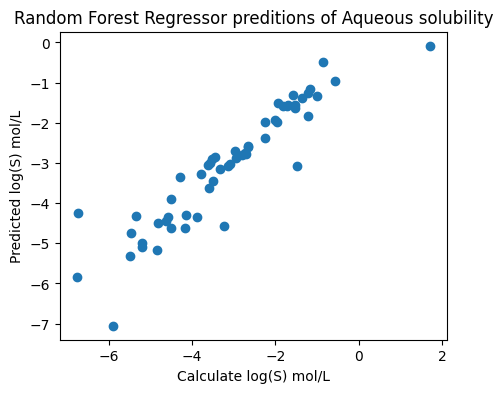

In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.scatter(y_test, pred_test)
plt.xlabel("Calculate log(S) mol/L")
plt.ylabel("Predicted log(S) mol/L")
plt.title("Random Forest Regressor preditions of Aqueous solubility")
plt.show()

In [332]:
import joblib

with open(file="model/regressors/solubility-rf-sklearn.model", mode="wb") as file:
    joblib.dump(value=random_forest, filename=file)

with open(file="model/regressors/solubility-standard-scaler-sklearn.model", mode="wb") as file:
    joblib.dump(value=scaler, filename=file)

In [333]:
import torch
import torch.nn.functional as F

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer_one = torch.nn.Linear(in_features=4, out_features=1)
        # self.layer_two = torch.nn.Linear(in_features=2, out_features=1)
        self.out = torch.nn.Linear(in_features=1, out_features=1)
    
    def forward(self, features) -> float:
        output = F.leaky_relu(self.layer_one(features))
        # output = F.leaky_relu(self.layer_two(output))
        output = self.out(output)
        
        return output

prediction_network = Network()

In [334]:
for _, parameter in enumerate(list(prediction_network.parameters()), start = 1):
    print(parameter)

Parameter containing:
tensor([[ 0.3380, -0.3253, -0.1653, -0.0661]], requires_grad=True)
Parameter containing:
tensor([0.0452], requires_grad=True)
Parameter containing:
tensor([[0.1289]], requires_grad=True)
Parameter containing:
tensor([-0.0917], requires_grad=True)


In [338]:
X_dataset_tensor, y_tensor = torch.tensor(X_dataset.to_numpy(), dtype=torch.float32), torch.tensor(y.to_numpy(), dtype=torch.float32)
X_test_tensor, y_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32)

optimizer = torch.optim.Adam(prediction_network.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for x, target in zip(X_dataset_tensor, y_tensor):
    optimizer.zero_grad()
    output = prediction_network(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()


In [340]:
total_loss: float = 0.0

for x, target in zip(X_test_tensor, y_test_tensor):
    output = prediction_network(x)
    loss = criterion(output, target)
    total_loss = total_loss + loss

print(f"Average loss: {total_loss/len(X_test_tensor)}")

Average loss: 1.0083614587783813


In [337]:
mean_loss = total_loss/len(X_test_tensor)

print(f"Testing RMSE: {torch.sqrt(mean_loss).detach().numpy()}")

Testing RMSE: 0.9805763363838196
